In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile, os

zip_path = "/content/drive/MyDrive/enhanced.zip"
extract_path = "/content/dataset"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

print(" Dataset extracted.")

 Dataset extracted.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3  # 🔄 Changed from ResNet152 to InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
train_dir = "/content/dataset/enhanced/train"
val_dir = "/content/dataset/enhanced/val"

from tensorflow.keras.preprocessing.image import ImageDataGenerator


# === Data generators ===
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

# === Load image data ===
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # ✅ Required input size for InceptionV3
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(299, 299),  # ✅ Required input size for InceptionV3
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 712 images belonging to 2 classes.
Found 848 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import InceptionV3  # 🔄 Changed from ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Load InceptionV3 as base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))  # 🔄 Updated input size

# Freeze initial layers
for layer in base_model.layers[:200]:  # 🔄 InceptionV3 has fewer layers than ResNet152
    layer.trainable = False

# Unfreeze later layers
for layer in base_model.layers[200:]:
    layer.trainable = True

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define optimizer
optimizer = SGD(learning_rate=0.01,momentum=0.9,nesterov=True)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Updated input shape for InceptionV3
model.build((None, 299, 299, 3))

# ✅ Updated checkpoint filename to reflect InceptionV3
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/best_inceptionv3_model.keras",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=21,
    callbacks=[checkpoint, lr_scheduler]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/21
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4082 - loss: 1.8536
Epoch 1: val_loss improved from inf to 5.29772, saving model to /content/drive/MyDrive/best_inceptionv3_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.4135 - loss: 1.8399 - val_accuracy: 0.5767 - val_loss: 5.2977 - learning_rate: 0.0100
Epoch 2/21
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.7585 - loss: 0.7631
Epoch 2: val_loss improved from 5.29772 to 2.36727, saving model to /content/drive/MyDrive/best_inceptionv3_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.7589 - loss: 0.7607 - val_accuracy: 0.4870 - val_loss: 2.3673 - learning_rate: 0.0100
Epoch 3/21
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.8215 - loss: 0.4704
Epoch 3: val_loss did not improve from 2.36727
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8213 - loss: 0.4714 - val_accuracy: 0.6392 - val_loss: 2.3756 - learning_rate: 0.0100
Epoch 4/21
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 82

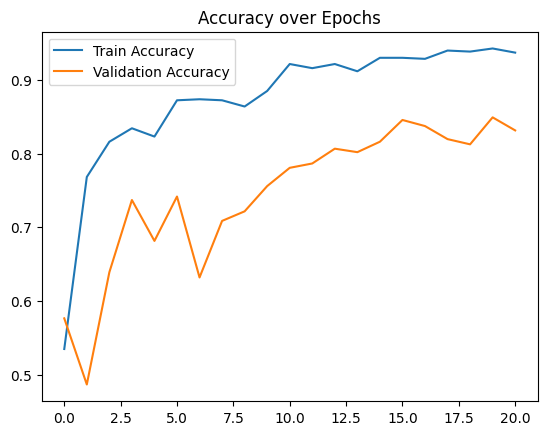

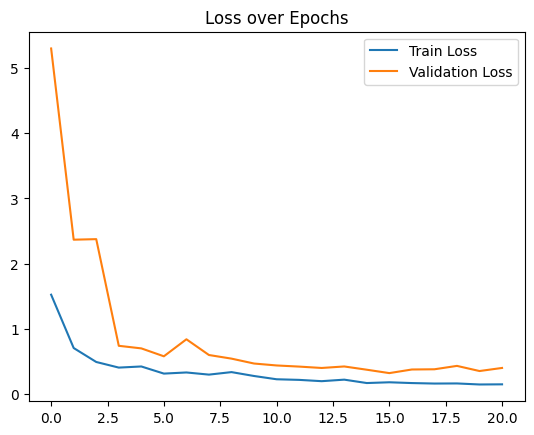

In [7]:
import matplotlib.pyplot as plt
import os

graph_dir = "/content/drive/MyDrive/diabetic_eye_results"
os.makedirs(graph_dir, exist_ok=True)

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(); plt.title("Accuracy over Epochs")
plt.savefig(f"{graph_dir}/accuracy_plot.png")
plt.show()

# Loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(); plt.title("Loss over Epochs")
plt.savefig(f"{graph_dir}/loss_plot.png")
plt.show()


✅ Model loaded from: /content/drive/MyDrive/best_inceptionv3_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 978ms/step
Unique y_true: [0 1]
Unique y_pred: [0 1]
Valid labels: [0, 1]
Target names: ['abnormal', 'normal']

Predicted sample count per class:
abnormal: 280
normal: 568

✅ Overall Validation Accuracy: 84.67%


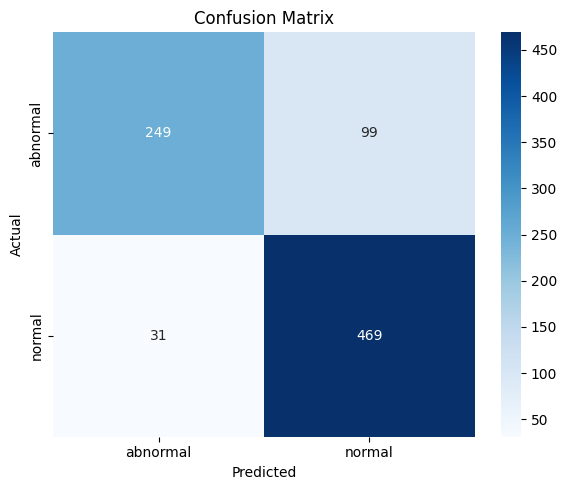


Classification Report:

              precision    recall  f1-score   support

    abnormal       0.89      0.72      0.79       348
      normal       0.83      0.94      0.88       500

    accuracy                           0.85       848
   macro avg       0.86      0.83      0.84       848
weighted avg       0.85      0.85      0.84       848



In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import load_model

# === Load the trained ResNet152 model ===
model_path = "/content/drive/MyDrive/best_inceptionv3_model.keras"
model = load_model(model_path)
print("✅ Model loaded from:", model_path)

# === Directory to save plots ===
graph_dir = "/content/drive/MyDrive/diabetic_eye_results"
os.makedirs(graph_dir, exist_ok=True)

# === Predict on validation data ===
val_data.reset()
pred_probs = model.predict(val_data, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_data.classes

# === Get class mapping ===
class_indices = val_data.class_indices
index_to_label = {v: k for k, v in class_indices.items()}
valid_labels = sorted(index_to_label.keys())
target_names = [index_to_label[i] for i in valid_labels]

# === Debug info ===
print("Unique y_true:", np.unique(y_true))
print("Unique y_pred:", np.unique(y_pred))
print("Valid labels:", valid_labels)
print("Target names:", target_names)

# === Optional: Check class prediction counts ===
print("\nPredicted sample count per class:")
pred_counter = collections.Counter(y_pred)
for label in valid_labels:
    print(f"{index_to_label[label]}: {pred_counter.get(label, 0)}")

# === Accuracy Score ===
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Overall Validation Accuracy: {accuracy * 100:.2f}%")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred, labels=valid_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{graph_dir}/confusion_matrix.png")
plt.show()

# === Classification Report ===
print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    labels=valid_labels,
    target_names=target_names,
    zero_division=0  # Prevents warnings when precision is undefined
))


⚠️ Skipping ROC curve for Class 2 — no positive samples in y_true.
⚠️ Skipping ROC curve for Class 3 — no positive samples in y_true.
⚠️ Skipping ROC curve for Class 4 — no positive samples in y_true.


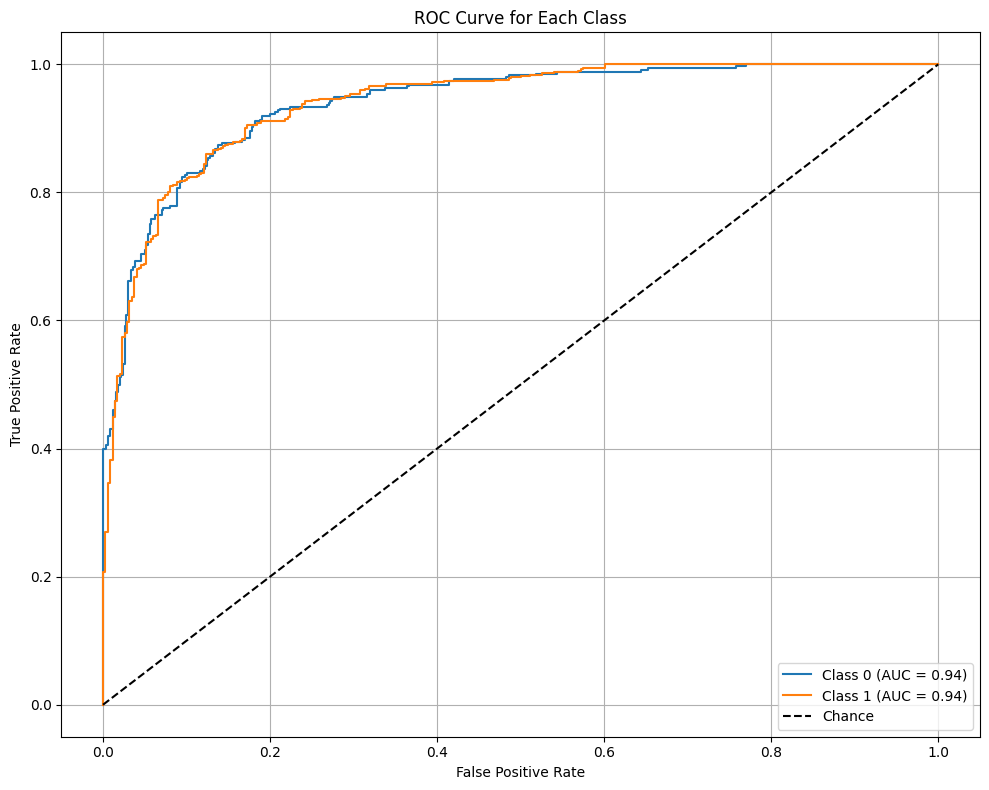


Skipped ROC for classes with no positive samples: Class 2, Class 3, Class 4
✅ ROC curve saved to: ./plots/roc_curve.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import os

# ---------- Required Inputs ----------
# y_true: true labels (e.g., [0, 2, 1, 4, ...]), shape = (n_samples,)
# pred_probs: predicted probabilities, shape = (n_samples, n_classes)
# labels: class names (optional, replace with your own)
# graph_dir: directory where to save plot

n_classes = 5
labels = [f'Class {i}' for i in range(n_classes)]  # Replace with actual names if needed
graph_dir = "./plots"

# Ensure output directory exists
os.makedirs(graph_dir, exist_ok=True)

# Binarize true labels for ROC computation
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Dictionaries to store ROC metrics
fpr, tpr, roc_auc = {}, {}, {}
missing_classes = []

# Compute ROC for each class
for i in range(n_classes):
    if np.sum(y_true_bin[:, i]) == 0:
        print(f"⚠️ Skipping ROC curve for {labels[i]} — no positive samples in y_true.")
        missing_classes.append(labels[i])
        continue
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ---------- Plot ROC Curves ----------
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    if i in roc_auc:
        plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# Save and show plot
plot_path = os.path.join(graph_dir, "roc_curve.png")
plt.savefig(plot_path)
plt.show()

# ---------- Summary ----------
if missing_classes:
    print(f"\nSkipped ROC for classes with no positive samples: {', '.join(missing_classes)}")
print(f"✅ ROC curve saved to: {plot_path}")


In [ ]:
model.save("/content/drive/MyDrive/final_resnet152_model.keras")